* 入力は80x80xグレースケール（主に計算時間の理由）
* VAEのエンコーダ部分、基本的に3x3コンボリューション＋2x2MaxPoolの繰り返し
* 潜在変数の数はlatent_dimで指定

In [1]:
import keras
from keras import Input, layers
from keras.models import Sequential,Model
from keras import backend as K
import numpy as np

img_shape = (80,80,1)
batch_size = 512
latent_dim = 8

input_img = keras.Input(shape=img_shape)
x = layers.SeparableConv2D(32, 3, padding="same", activation="elu", kernel_initializer="he_normal")(input_img)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(64, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(64, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.MaxPooling2D()(x)
x = layers.SeparableConv2D(96, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(48, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="elu", kernel_initializer="he_normal")(x)

z_mean = layers.Dense(latent_dim, kernel_initializer="he_normal")(x)
z_log_var = layers.Dense(latent_dim, kernel_initializer="he_normal")(x)

encoder = Model(input_img, z_mean)

Using TensorFlow backend.


* デコード部分(訓練時のみ使用)
* こちらも基本デコンボリューションによるアップスケールの繰り返し
* 最後につけている3x3→1x1の部分はloss減少を狙ったものだがどの程度効いているかは未検証、気休め？

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + epsilon * K.exp(z_log_var)

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [3]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation="elu", kernel_initializer="he_normal")(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(64, 3, padding="same", activation="elu", strides=(2,2), kernel_initializer="he_normal")(x)
x = layers.Conv2DTranspose(64, 3, padding="same", activation="elu", strides=(2,2), kernel_initializer="he_normal")(x)
x = layers.Conv2DTranspose(32, 3, padding="same", activation="elu", strides=(2,2), kernel_initializer="he_normal")(x)
x = layers.SeparableConv2D(32, 3, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(32, 1, padding="same", activation="elu", kernel_initializer="he_normal")(x)
x = layers.Conv2D(1, 3, padding="same", activation="sigmoid", kernel_initializer="he_normal")(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [4]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

* モデル構築して内容確認

In [5]:
from keras.preprocessing import image
import glob
import matplotlib.pyplot as plt
from keras import optimizers
%matplotlib inline

vae = Model(input_img, y)
vae.compile(optimizer="rmsprop", loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 80, 80, 32)   73          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 40, 32)   0           separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 40, 40, 64)   2400        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_1 (

* 画像入力のための変換はkerasのImageDataGeneratorを使用
* zoom_range=0.5にして口元を拡大（全体を入れると服や背景の表現にも潜在変数が使われてしまう）

In [6]:
my_zoom_range = [0.5,0.5]
path = "D:/MLData/kyushu_k_SSSD/training/".replace('\\','/')
files = glob.glob(path + "/*/*/*.jpg")
TOTAL_DATANUM = len(files)
train_datagen = image.ImageDataGenerator(
    rescale=1./255.,
    zoom_range=my_zoom_range,
)
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(img_shape[0],img_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
)

Found 1317836 images belonging to 39 classes.


* 効率よくデータを突っ込むためImageDataGeneratorの実行は別スレッドにする

In [7]:
import threading
import queue

class QueuePutter:
    def __init__(self, queue, generator):
        self.queue = queue
        self.generator = generator
        
    def start(self, numworker):
        self.running = True
        self.threads = [threading.Thread(target=self.run) for _ in range(numworker)]
        for t in self.threads:
            t.start()
            
    def stop(self):
        self.running = False
        while not self.queue.empty():
            self.queue.get()
        for t in self.threads:
            t.join()
            
    def run(self):
        while self.running:
            batch = self.generator.next()
            self.queue.put(batch)

* 訓練は全サンプル..としたいがとても時間が掛かるので適当に切り上げ
* 訓練数による潜在変数精度への影響は定量調査できてない、下の画像の出来具合で判断

In [8]:
img_queue = queue.Queue(2)
qp = QueuePutter(img_queue, train_generator)
qp.start(2)

for i in range(1000):#(TOTAL_DATANUM+batch_size-1)//batch_size):
    batch = img_queue.get()
    vae.fit(
        x=batch[0],y=None,
        steps_per_epoch=32,
        initial_epoch=i,
        epochs=(i+1),
    )

qp.stop()

Epoch 1/1
32/32 [==============================] - 33s 1s/step - loss: 0.6708
Epoch 2/2
32/32 [==============================] - 30s 938ms/step - loss: 0.6467
Epoch 3/3
32/32 [==============================] - 30s 941ms/step - loss: 0.6480
Epoch 4/4
32/32 [==============================] - 30s 947ms/step - loss: 0.6478
Epoch 5/5
32/32 [==============================] - 30s 944ms/step - loss: 0.6487
Epoch 6/6
32/32 [==============================] - 30s 943ms/step - loss: 0.6472
Epoch 7/7
32/32 [==============================] - 30s 943ms/step - loss: 0.6461
Epoch 8/8
32/32 [==============================] - 30s 939ms/step - loss: 0.6489
Epoch 9/9
32/32 [==============================] - 30s 937ms/step - loss: 0.6470
Epoch 10/10
32/32 [==============================] - 30s 937ms/step - loss: 0.6437
Epoch 11/11
32/32 [==============================] - 30s 944ms/step - loss: 0.6481
Epoch 12/12
32/32 [==============================] - 30s 940ms/step - loss: 0.6468
Epoch 13/13
32/32 [======

Epoch 100/100
32/32 [==============================] - 30s 935ms/step - loss: 0.6460
Epoch 101/101
32/32 [==============================] - 30s 934ms/step - loss: 0.6451
Epoch 102/102
32/32 [==============================] - 30s 933ms/step - loss: 0.6455
Epoch 103/103
32/32 [==============================] - 30s 929ms/step - loss: 0.6455
Epoch 104/104
32/32 [==============================] - 30s 938ms/step - loss: 0.6467
Epoch 105/105
32/32 [==============================] - 29s 921ms/step - loss: 0.6478
Epoch 106/106
32/32 [==============================] - 30s 941ms/step - loss: 0.6442
Epoch 107/107
32/32 [==============================] - 30s 942ms/step - loss: 0.6455
Epoch 108/108
32/32 [==============================] - 30s 938ms/step - loss: 0.6460
Epoch 109/109
32/32 [==============================] - 30s 943ms/step - loss: 0.6445
Epoch 110/110
32/32 [==============================] - 30s 939ms/step - loss: 0.6453
Epoch 111/111
32/32 [==============================] - 30s 939ms/

32/32 [==============================] - 30s 937ms/step - loss: 0.6444
Epoch 293/293
32/32 [==============================] - 30s 932ms/step - loss: 0.6460
Epoch 294/294
32/32 [==============================] - 30s 935ms/step - loss: 0.6452
Epoch 295/295
32/32 [==============================] - 30s 933ms/step - loss: 0.6450
Epoch 296/296
32/32 [==============================] - 30s 937ms/step - loss: 0.6432
Epoch 297/297
32/32 [==============================] - 30s 936ms/step - loss: 0.6460
Epoch 298/298
32/32 [==============================] - 30s 939ms/step - loss: 0.6449
Epoch 299/299
32/32 [==============================] - 30s 938ms/step - loss: 0.6446
Epoch 300/300
32/32 [==============================] - 30s 930ms/step - loss: 0.6440
Epoch 301/301
32/32 [==============================] - 30s 941ms/step - loss: 0.6449
Epoch 302/302
32/32 [==============================] - 30s 938ms/step - loss: 0.6449
Epoch 303/303
32/32 [==============================] - 30s 930ms/step - loss: 0

32/32 [==============================] - 30s 942ms/step - loss: 0.6436
Epoch 485/485
32/32 [==============================] - 30s 941ms/step - loss: 0.6419
Epoch 486/486
32/32 [==============================] - 30s 926ms/step - loss: 0.6452
Epoch 487/487
32/32 [==============================] - 30s 937ms/step - loss: 0.6436
Epoch 488/488
32/32 [==============================] - 30s 938ms/step - loss: 0.6450
Epoch 489/489
32/32 [==============================] - 30s 930ms/step - loss: 0.6433
Epoch 490/490
32/32 [==============================] - 30s 939ms/step - loss: 0.6453
Epoch 491/491
32/32 [==============================] - 30s 932ms/step - loss: 0.6435
Epoch 492/492
32/32 [==============================] - 30s 941ms/step - loss: 0.6454
Epoch 493/493
32/32 [==============================] - 30s 942ms/step - loss: 0.6463
Epoch 494/494
32/32 [==============================] - 30s 940ms/step - loss: 0.6450
Epoch 495/495
32/32 [==============================] - 30s 934ms/step - loss: 0

32/32 [==============================] - 30s 929ms/step - loss: 0.6429
Epoch 677/677
32/32 [==============================] - 30s 942ms/step - loss: 0.6435
Epoch 678/678
32/32 [==============================] - 30s 941ms/step - loss: 0.6452
Epoch 679/679
32/32 [==============================] - 30s 938ms/step - loss: 0.6443
Epoch 680/680
32/32 [==============================] - 30s 939ms/step - loss: 0.6432
Epoch 681/681
32/32 [==============================] - 30s 935ms/step - loss: 0.6429
Epoch 682/682
32/32 [==============================] - 30s 939ms/step - loss: 0.6429
Epoch 683/683
32/32 [==============================] - 30s 932ms/step - loss: 0.6445
Epoch 684/684
32/32 [==============================] - 30s 940ms/step - loss: 0.6435
Epoch 685/685
32/32 [==============================] - 30s 930ms/step - loss: 0.6445
Epoch 686/686
32/32 [==============================] - 30s 939ms/step - loss: 0.6436
Epoch 687/687
32/32 [==============================] - 30s 937ms/step - loss: 0

32/32 [==============================] - 30s 929ms/step - loss: 0.6435
Epoch 869/869
32/32 [==============================] - 30s 945ms/step - loss: 0.6452
Epoch 870/870
32/32 [==============================] - 30s 943ms/step - loss: 0.6429
Epoch 871/871
32/32 [==============================] - 30s 930ms/step - loss: 0.6425
Epoch 872/872
32/32 [==============================] - 30s 940ms/step - loss: 0.6409
Epoch 873/873
32/32 [==============================] - 30s 942ms/step - loss: 0.6449
Epoch 874/874
32/32 [==============================] - 30s 932ms/step - loss: 0.6434
Epoch 875/875
32/32 [==============================] - 30s 934ms/step - loss: 0.6441
Epoch 876/876
32/32 [==============================] - 30s 941ms/step - loss: 0.6455
Epoch 877/877
32/32 [==============================] - 30s 928ms/step - loss: 0.6426
Epoch 878/878
32/32 [==============================] - 30s 932ms/step - loss: 0.6434
Epoch 879/879
32/32 [==============================] - 30s 938ms/step - loss: 0

* 適当な2次元を振って、潜在変数→デコードが正しくできるか目視確認
* lossは入力画像vsデコード画像なので、デコード後の出来が良ければ間接的にエンコーダの出来も良いと言える(?)

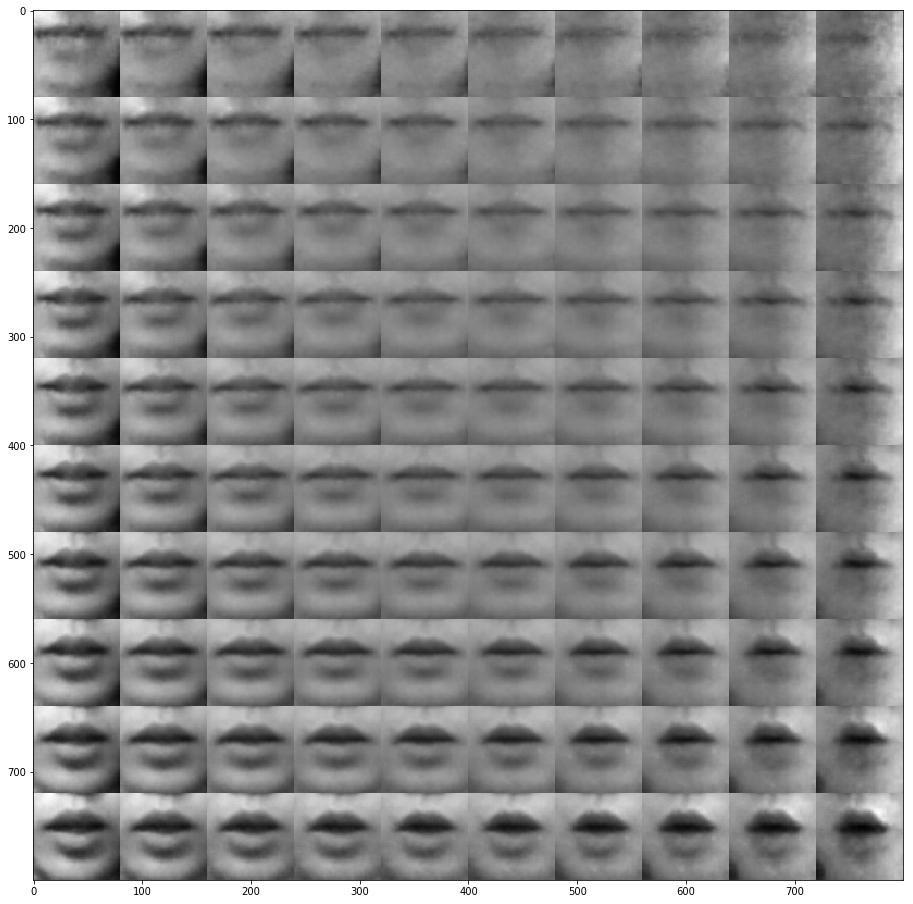

In [9]:
from scipy.stats import norm

n = 10
img_size = img_shape[0]
figure = np.empty((img_size * n, img_size * n))
grid_x = norm.ppf(np.linspace(0.05,.95,n))
grid_y = norm.ppf(np.linspace(0.05,.95,n))
grid_other = norm.ppf(0.5)
for i,yi in enumerate(grid_y):
    for j,xi in enumerate(grid_x):
        z_sample = np.array([[grid_other]*latent_dim])
        z_sample[0][0] = xi
        z_sample[0][1] = yi
        z_sample = np.tile(z_sample,batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(img_size,img_size)
        figure[i*img_size:(i+1)*img_size, j*img_size:(j+1)*img_size] = digit
plt.figure(figsize=(16,16))
plt.imshow(figure, cmap="gray")
plt.show()

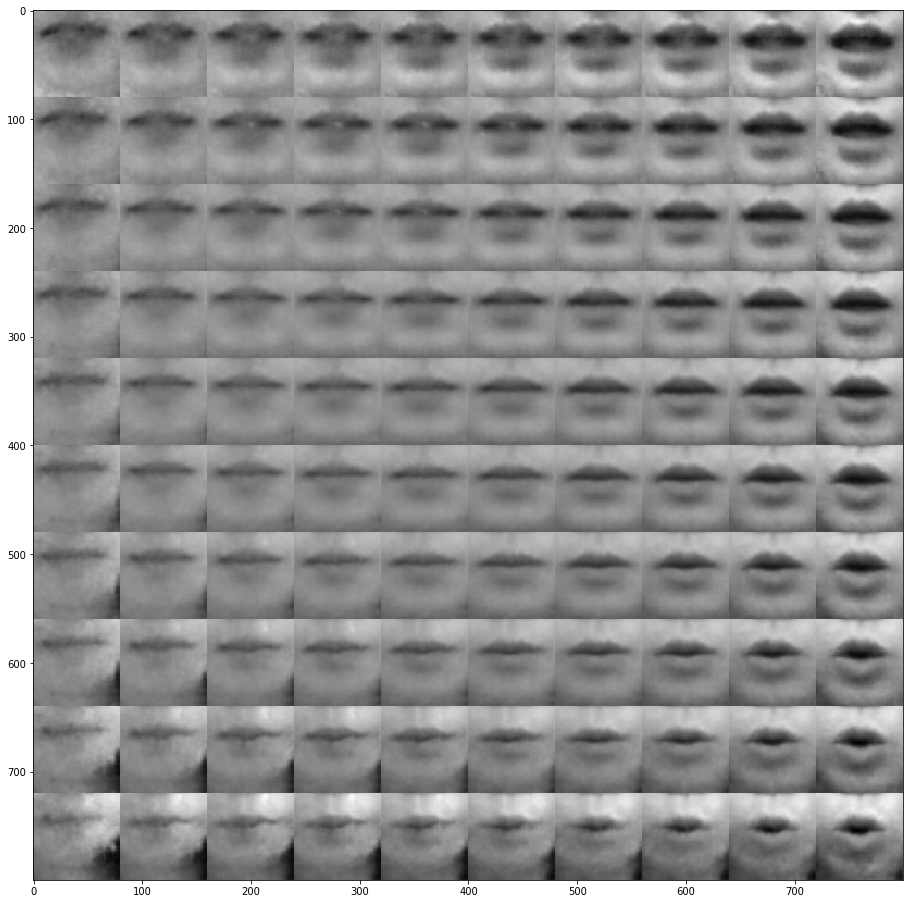

In [10]:
from scipy.stats import norm

n = 10
img_size = img_shape[0]
figure = np.empty((img_size * n, img_size * n))
grid_x = norm.ppf(np.linspace(0.05,.95,n))
grid_y = norm.ppf(np.linspace(0.05,.95,n))
grid_other = norm.ppf(0.5)
for i,yi in enumerate(grid_y):
    for j,xi in enumerate(grid_x):
        z_sample = np.array([[grid_other]*latent_dim])
        z_sample[0][1] = xi
        z_sample[0][2] = yi
        z_sample = np.tile(z_sample,batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(img_size,img_size)
        figure[i*img_size:(i+1)*img_size, j*img_size:(j+1)*img_size] = digit
plt.figure(figsize=(16,16))
plt.imshow(figure, cmap="gray")
plt.show()

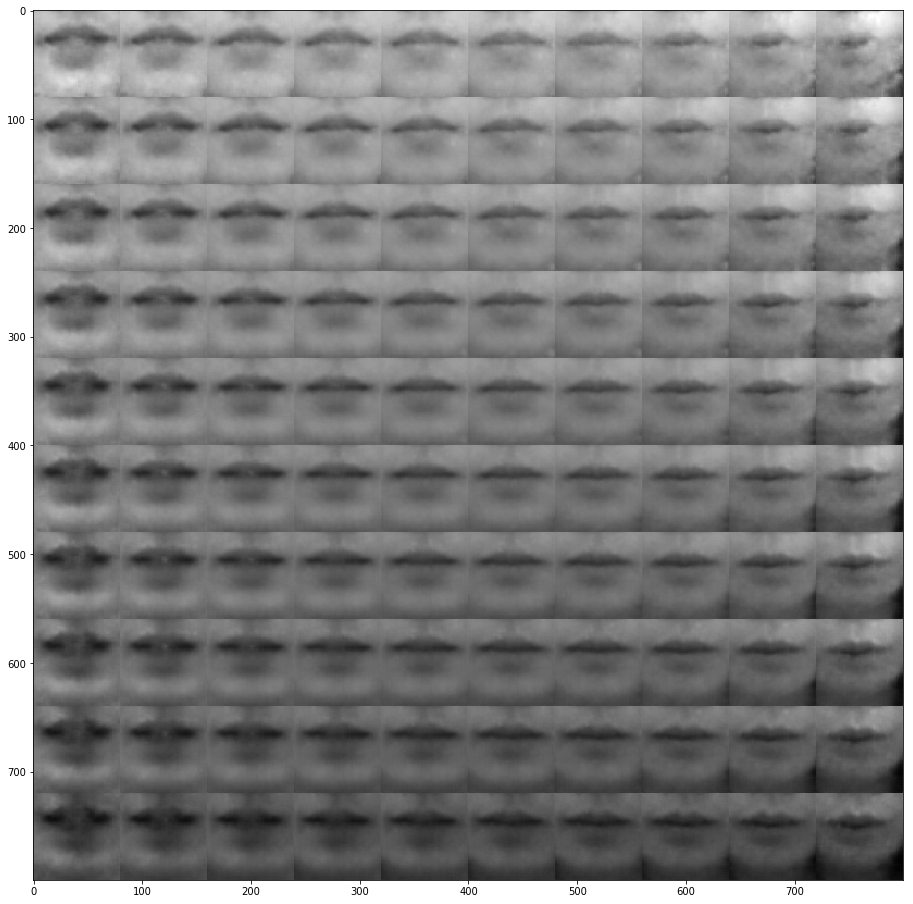

In [11]:
from scipy.stats import norm

n = 10
img_size = img_shape[0]
figure = np.empty((img_size * n, img_size * n))
grid_x = norm.ppf(np.linspace(0.05,.95,n))
grid_y = norm.ppf(np.linspace(0.05,.95,n))
grid_other = norm.ppf(0.5)
for i,yi in enumerate(grid_y):
    for j,xi in enumerate(grid_x):
        z_sample = np.array([[grid_other]*latent_dim])
        z_sample[0][2] = xi
        z_sample[0][3] = yi
        z_sample = np.tile(z_sample,batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(img_size,img_size)
        figure[i*img_size:(i+1)*img_size, j*img_size:(j+1)*img_size] = digit
plt.figure(figsize=(16,16))
plt.imshow(figure, cmap="gray")
plt.show()

* 後で復帰できるよう重みデータを保存

In [12]:
from datetime import datetime
import os
logdir = "./keras_log/run-{}/".format(datetime.utcnow().strftime("%Y%m%d%H%M%S"))

if not os.path.exists(logdir):
    os.makedirs(logdir)

json_string = vae.to_json()
with open(logdir + 'SSSD_challenge_model.json','w') as w:
    w.write(json_string)

vae.save_weights(logdir + 'SSSD_challenge_weights.h5')

* エンコーダ部分のみを使い、画像データ群を時系列潜在変数の配列に変換

In [13]:
def get_encoded_df(root_path):
    files = glob.glob(root_path + "/*/*.jpg")
    numframes = len(files)
    batch_size = 32
    datagen = image.ImageDataGenerator(
        rescale=1./255.,
        zoom_range=my_zoom_range,
    )
    encode_generator = datagen.flow_from_directory(
        root_path,
        target_size=(img_shape[0],img_shape[1]),
        class_mode='binary',
        color_mode='grayscale',
        batch_size=batch_size,
        shuffle=False,
    )
    result = []
    for i in range((numframes+batch_size-1)//batch_size):
        batch = encode_generator.next()
        z_sample = encoder.predict(x=batch[0])
        classes=batch[1]
        result.append({"z":z_sample, "class":classes})
    classes = np.hstack([result[i]["class"] for i in range(len(result))])
    z_sample = np.vstack([result[i]["z"] for i in range(len(result))])
    
    return classes, z_sample

def create_result(from_path, to_path):
    cls,z_sample = get_encoded_df(from_path)
    unique,counts = np.unique(cls,return_counts=True)
    maxlen = np.max(counts)
    arrays = []
    for i in range(np.max(cls).astype(int) + 1):
        data = z_sample[cls==i]
        nans = np.empty((maxlen,z_sample.shape[1]),dtype=np.float)
        nans[:,:] = np.nan
        nans[:len(data),:] = data
        arrays.append(nans)
        
    data = np.stack(arrays)
    label = np.arange(25).repeat(30)
    person_str = from_path.replace("\\","/")
    person_str = person_str[person_str.rfind("/")+1:]
    np.savez(to_path + person_str + ".npz",data=data,label=label)

In [15]:
import threading
def createResultWorker(sem,from_path,to_path):
    with sem:
        create_result(from_path, to_path)

traindata_path = "D:/MLData/kyushu_k_SSSD/training/"
person_dir_list = glob.glob(path + "/s[0-3][0-9]")

sem = threading.Semaphore(4)
my_threads = [threading.Thread(target=createResultWorker,args=(sem,fromdir,logdir)) for fromdir in person_dir_list]
for my_thread in my_threads:
    my_thread.start()
    
for my_thread in my_threads:
    my_thread.join()

Found 30631 images belonging to 750 classes.
Found 33769 images belonging to 750 classes.
Found 37206 images belonging to 750 classes.
Found 37560 images belonging to 750 classes.
Found 34573 images belonging to 750 classes.
Found 36228 images belonging to 750 classes.
Found 41020 images belonging to 750 classes.
Found 37259 images belonging to 750 classes.
Found 39310 images belonging to 750 classes.
Found 34172 images belonging to 750 classes.
Found 32940 images belonging to 750 classes.
Found 36842 images belonging to 750 classes.
Found 34996 images belonging to 750 classes.
Found 42172 images belonging to 750 classes.
Found 38823 images belonging to 750 classes.
Found 34690 images belonging to 750 classes.
Found 42513 images belonging to 750 classes.
Found 39206 images belonging to 750 classes.
Found 43402 images belonging to 750 classes.
Found 33838 images belonging to 750 classes.
Found 35852 images belonging to 750 classes.
Found 41483 images belonging to 750 classes.
Found 4999

In [ ]:
testdata_path = "D:/MLData/kyushu_k_SSSD/test/"
testdir_list = glob.glob(testdata_path + "*000")

def create_test(from_path, to_path):
    cls,z_sample = get_encoded_df(from_path)
    unique,counts = np.unique(cls,return_counts=True)
    maxlen = np.max(counts)
    arrays = []
    for i in range(np.max(cls).astype(int) + 1):
        data = z_sample[cls==i]
        nans = np.empty((maxlen,z_sample.shape[1]),dtype=np.float)
        nans[:,:] = np.nan
        nans[:len(data),:] = data
        arrays.append(nans)
        
    data = np.stack(arrays)
    np.savez(to_path + "test.npz",data=data)
    
def createTestWorker(sem,from_path,to_path):
    with sem:
        create_test(from_path, to_path)

sem = threading.Semaphore(5)
my_threads = [threading.Thread(target=createResultWorker,args=(sem,fromdir,logdir)) for fromdir in testdir_list]
for my_thread in my_threads:
    my_thread.start()
    
for my_thread in my_threads:
    my_thread.join()

Found 48071 images belonging to 1000 classes.
Found 47458 images belonging to 1000 classes.
Found 47684 images belonging to 1000 classes.
Found 47655 images belonging to 1000 classes.
Found 48046 images belonging to 1000 classes.
